# 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings 
warnings.filterwarnings('ignore')

dataset_AMTX = '/content/drive/MyDrive/aiffel csv/AMTX.csv'
df_AMTX = pd.read_csv(dataset_AMTX)
ts_AMTX = df_AMTX['Close']

ts_AMTX.tail() 

# 종가(Close)만 사용하겠습니다...

247    5.30
248    5.18
249    5.42
250    5.76
251    5.57
Name: Close, dtype: float64

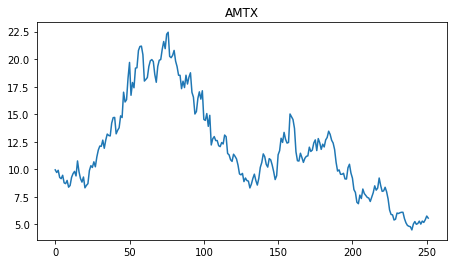

In [2]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 25,4

plt.subplot(131)
plt.plot(ts_AMTX)
plt.title('AMTX')

plt.show()
#그래프가 절망적이군요

각종 전처리 수행
- 결측치 처리
- 로그 변환

In [3]:
print(ts_AMTX[ts_AMTX.isna()])
#결측치가 없군요

Series([], Name: Close, dtype: float64)


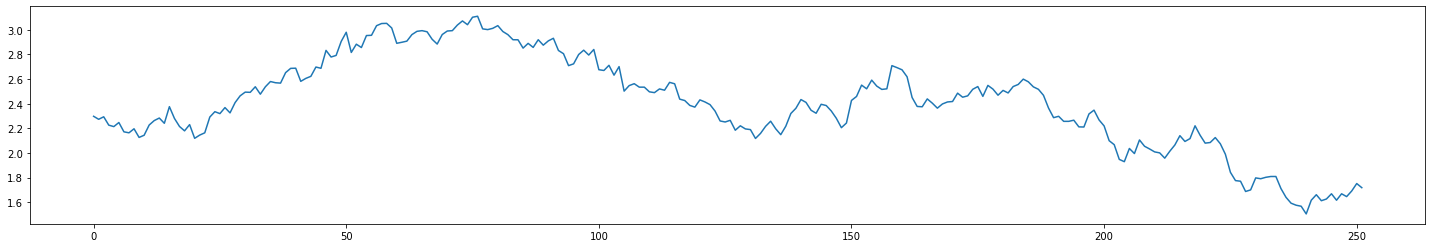

In [4]:
ts_AMTX_log = np.log(ts_AMTX)
plt.plot(ts_AMTX_log)

# 로그 변환

# 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해
- Reisdual 안정성 확인


In [5]:
# 정성적 그래프 분석  

def plot_rolling_statistics(timeseires, window=12):  # 이동 평균과 표준편차 그래프를 그려주는 함수

    rolmean = timeseires.rolling(window=window).mean()
    rolstd = timeseires.rolling(window=window).std()

    orig = plt.plot(timeseires, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

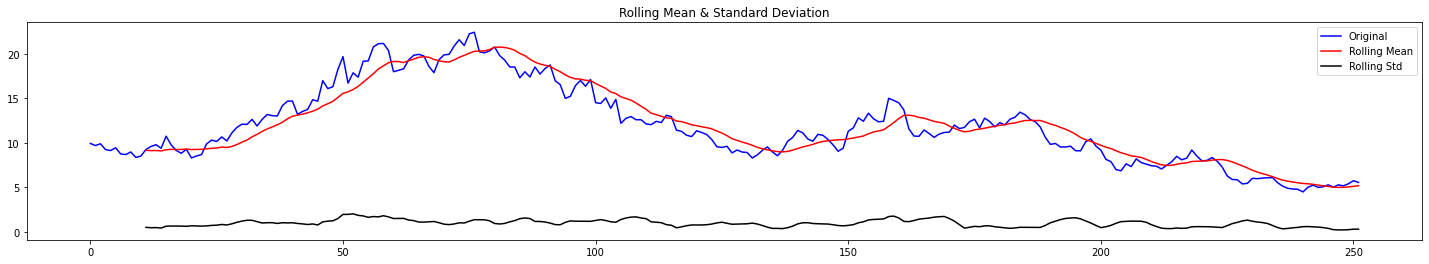

In [6]:
plot_rolling_statistics(ts_AMTX)

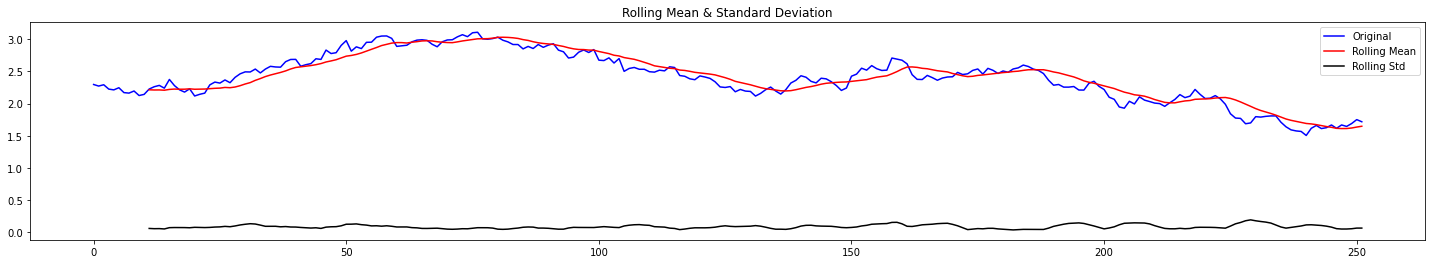

In [7]:
plot_rolling_statistics(ts_AMTX_log, window=12)

In [8]:
#정량적 Augmented Dicky-Fuller Test
#adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드   

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(Close):

    dftest = adfuller(Close ,autolag='AIC')
  # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [9]:
augmented_dickey_fuller_test(ts_AMTX_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.661580
p-value                          0.856452
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


p-value 값이 0.85네요 흠....

In [10]:
! pip install --upgrade statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


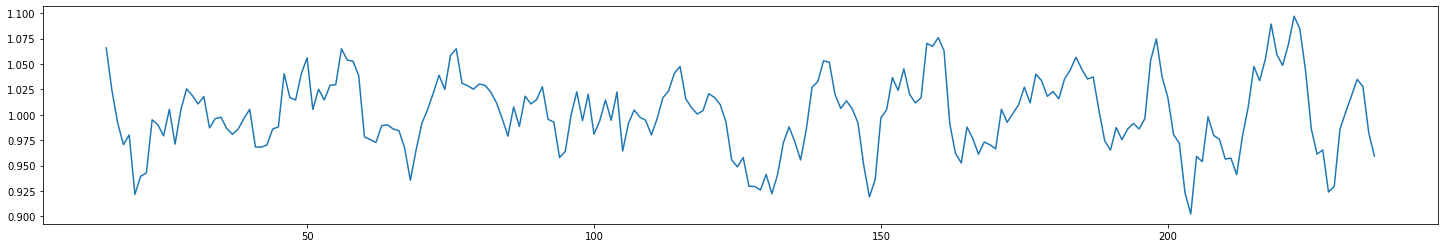

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

dp_AMTX = seasonal_decompose(ts_AMTX_log, model='multiplicative', period = 30)
rd_AMTX = dp_AMTX.resid
plt.plot(rd_AMTX)
plt.show()

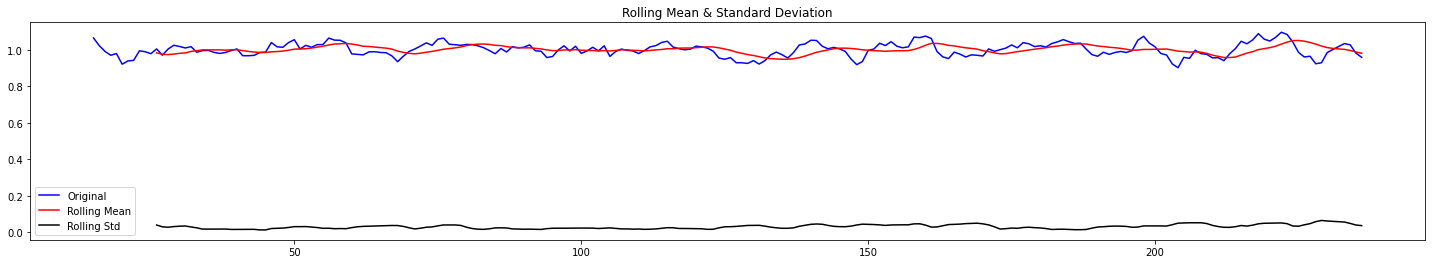

In [12]:
plot_rolling_statistics(rd_AMTX)

In [13]:
rd_AMTX.dropna(inplace=True)
augmented_dickey_fuller_test(rd_AMTX)

Results of Dickey-Fuller Test:
Test Statistic                -6.169557e+00
p-value                        6.857858e-08
#Lags Used                     2.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


p-value 값이 굉장히 안정적이게 되었습니다

# 학습,테스트 데이터셋 생성

- 학습,테스트 데이터셋 분리

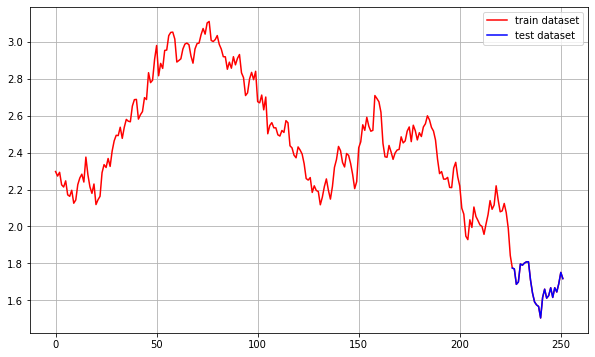

In [14]:
train_AMTX_data, test_AMTX_data = ts_AMTX_log[:int(len(ts_AMTX_log)*0.9)], ts_AMTX_log[int(len(ts_AMTX_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_AMTX_log, c='r' , label='train dataset')
plt.plot(test_AMTX_data, c='b', label='test dataset')        

plt.legend()


# 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 ->p,q구하기
- 차분 안정성 확인 -> d 구하기

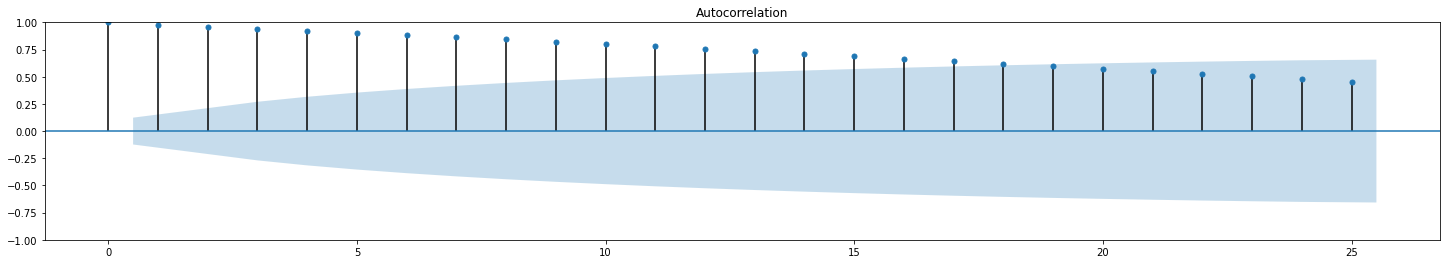

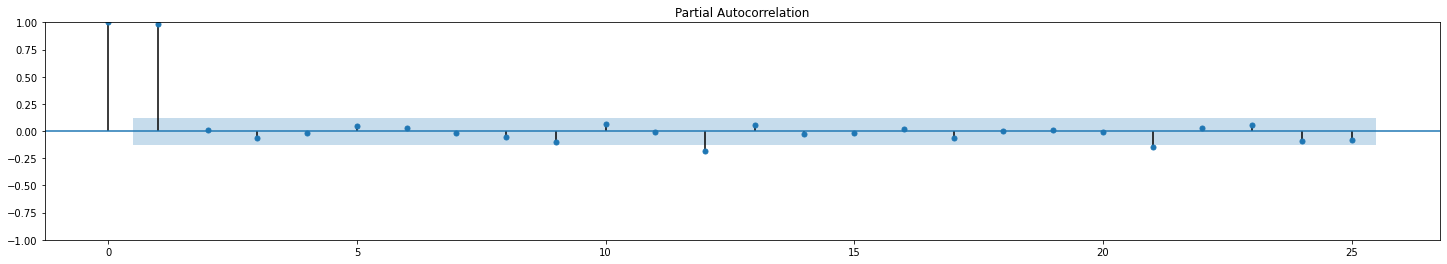

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_AMTX_log) # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_AMTX_log) # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.582313e+01
p-value                        1.014629e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


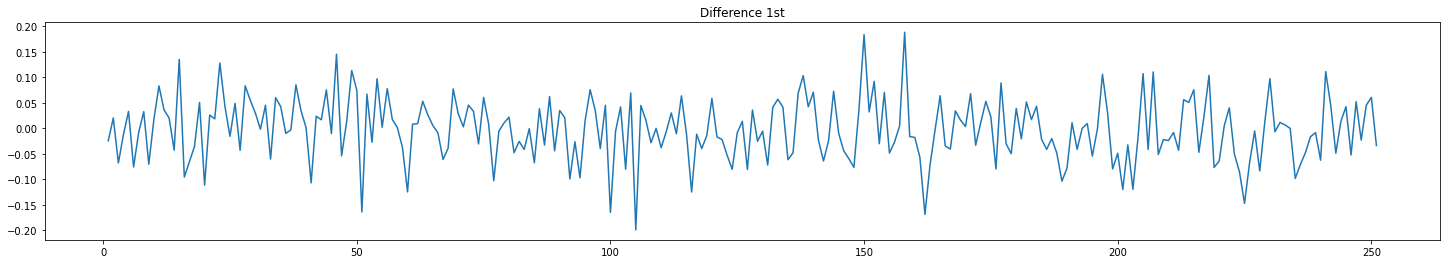

In [16]:
#1차 차분 구하기

diff_1 = ts_AMTX_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -9.456070e+00
p-value                        4.481721e-16
#Lags Used                     9.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


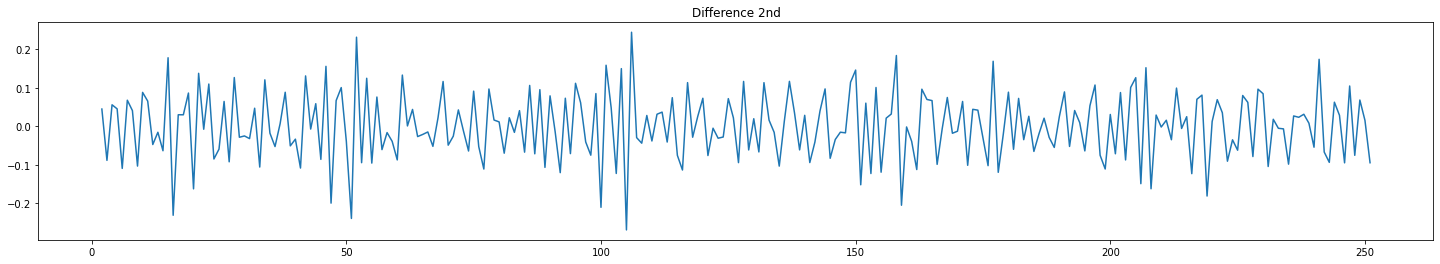

In [17]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [22]:
#ARIMA 모델 빌드와 훈련

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_AMTX_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 304.576
Date:                Fri, 29 Jul 2022   AIC                           -605.151
Time:                        14:33:08   BIC                           -598.319
Sample:                             0   HQIC                          -602.394
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0173      0.077     -0.226      0.821      -0.168       0.133
sigma2         0.0039      0.000     11.815      0.000       0.003       0.005
Ljung-Box (L1) (Q):                   0.00   Jarque-

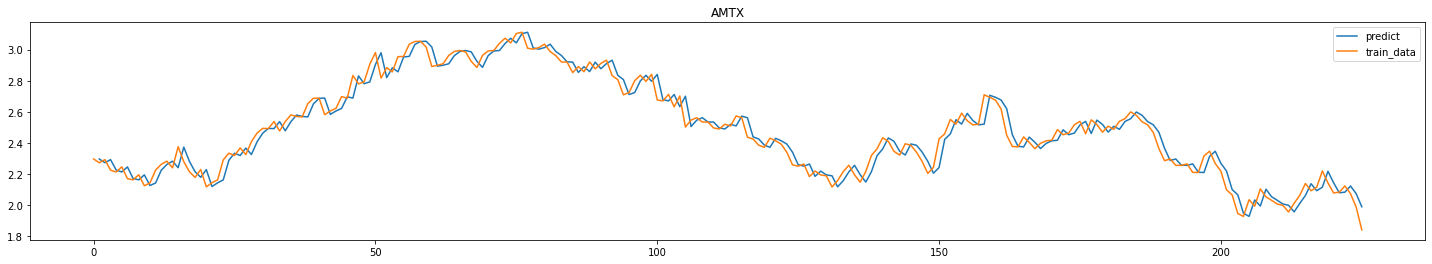

In [70]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_AMTX_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit()
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_AMTX_data, label='train_data')
plt.title('AMTX')
plt.legend()
plt.show()


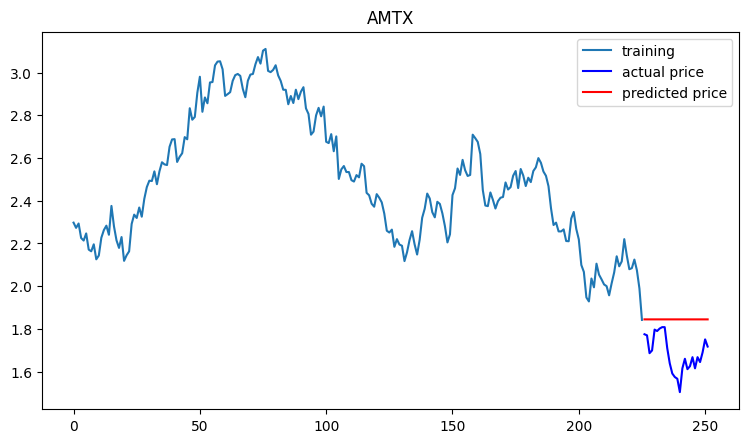

In [27]:
model = ARIMA(train_AMTX_data, order=(1, 1, 0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_AMTX_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_AMTX_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_AMTX_data, label='training')
plt.plot(test_AMTX_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.title('AMTX')
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_AMTX_data), np.exp(fc))
print('MSE:', mse)

mae = mean_absolute_error(np.exp(test_AMTX_data), np.exp(fc))
print('MAE:', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_AMTX_data), np.exp(fc)))
print('RMSE:', rmse )

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_AMTX_data))/np.abs(np.exp(test_AMTX_data)))
print('MAPE: {:.2f}%.'.format(mape*100))

MSE: 1.0465067893288384
MAE: 0.9192901574118763
RMSE: 1.0229891442868972
MAPE: 17.82%.


# 회고 

잘 되고 있었지만 period 에서 오류가 났고 도대체 뭐가 틀린지를 몰랐단 찰라에 민기님도 이부분에서 헤매었다고 했고 이유는 statasmodels 버젼을 업그레이드 해야된다고 했고 진짜로 업그레이드를 하니 해결이 되었습니다. 속이펑~


주식은 역시 예측할수없습니다 !

나머지 2개의 주식 예측도 복붙이 아닌 
일일히 다시 해보겠습니다 

In [29]:
dataset_KOLD = '/content/drive/MyDrive/aiffel csv/KOLD.csv'
df_KOLD = pd.read_csv(dataset_KOLD)
ts_KOLD = df_KOLD['Close']

ts_KOLD.tail()

247    14.90
248    13.43
249    13.05
250    13.35
251    14.61
Name: Close, dtype: float64

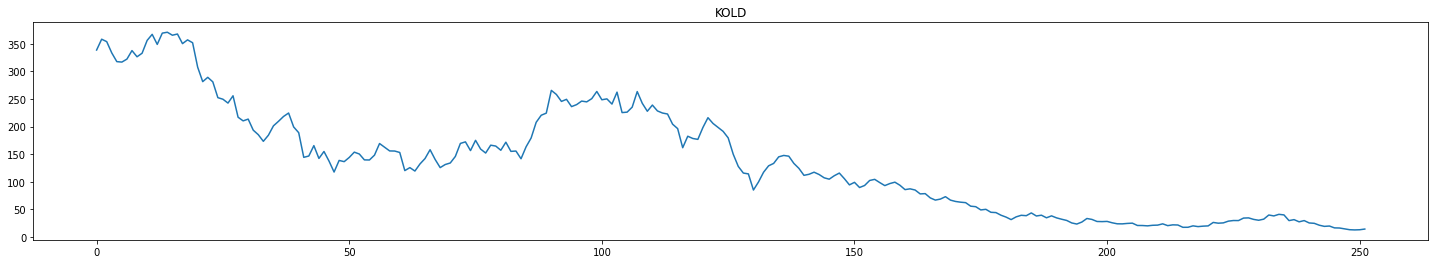

In [30]:
rcParams['figure.figsize'] = 25,4

plt.plot(ts_KOLD)
plt.title('KOLD')

plt.show()

In [31]:
print(ts_AMTX[ts_KOLD.isna()])

Series([], Name: Close, dtype: float64)


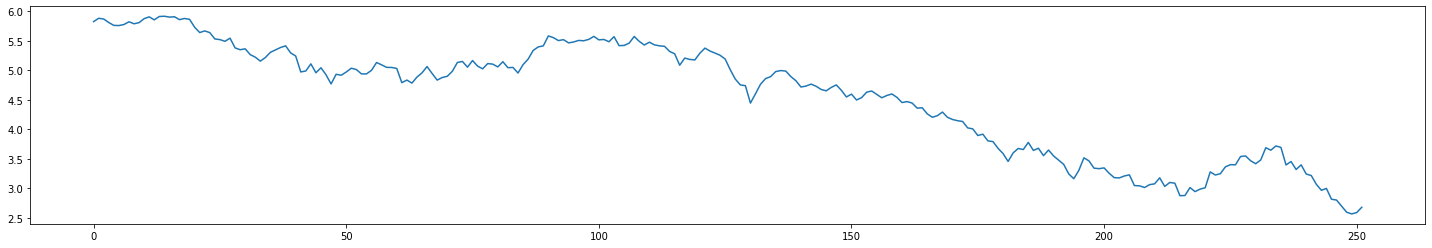

In [32]:
ts_KOLD_log = np.log(ts_KOLD)
plt.plot(ts_KOLD_log)

# 로그 변환

In [33]:
def plot_rolling_statistics(timeseires, window=12):  # 이동 평균과 표준편차 그래프를 그려주는 함수

    rolmean = timeseires.rolling(window=window).mean()
    rolstd = timeseires.rolling(window=window).std()

    orig = plt.plot(timeseires, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

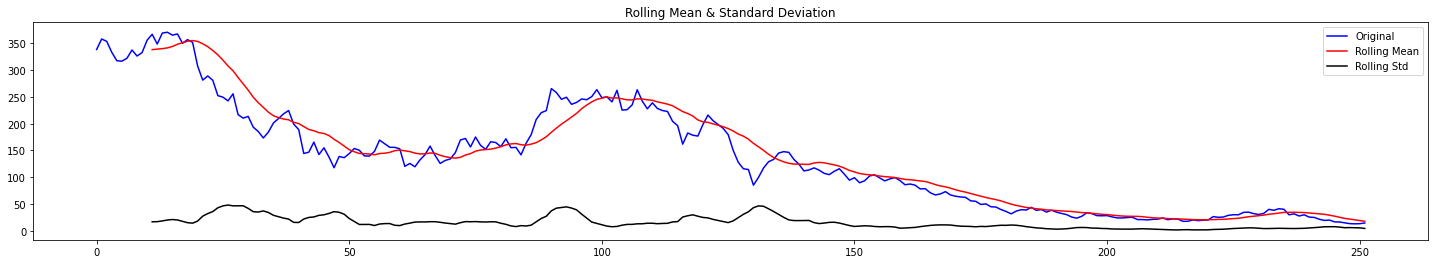

In [34]:
plot_rolling_statistics(ts_KOLD)

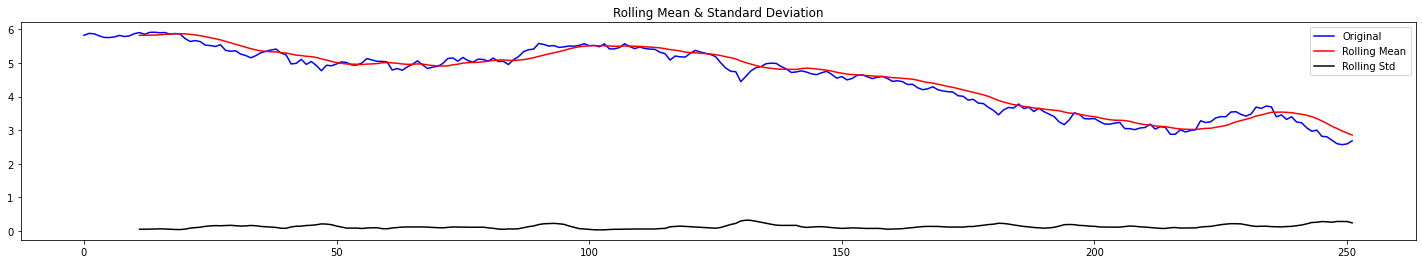

In [35]:
plot_rolling_statistics(ts_KOLD_log, window=12)

In [37]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(Close):

    dftest = adfuller(Close ,autolag='AIC')
 
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [38]:
augmented_dickey_fuller_test(ts_KOLD_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.026795
p-value                          0.956259
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


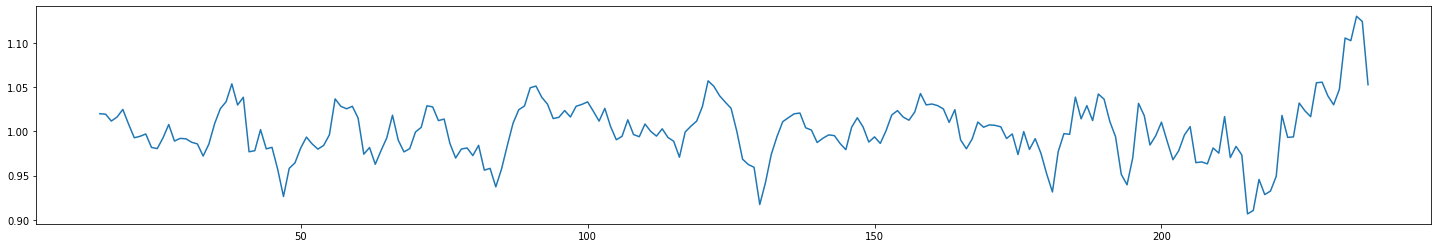

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

dp_KOLD = seasonal_decompose(ts_KOLD_log, model='multiplicative', period = 30)
rd_KOLD = dp_KOLD.resid
plt.plot(rd_KOLD)
plt.show()

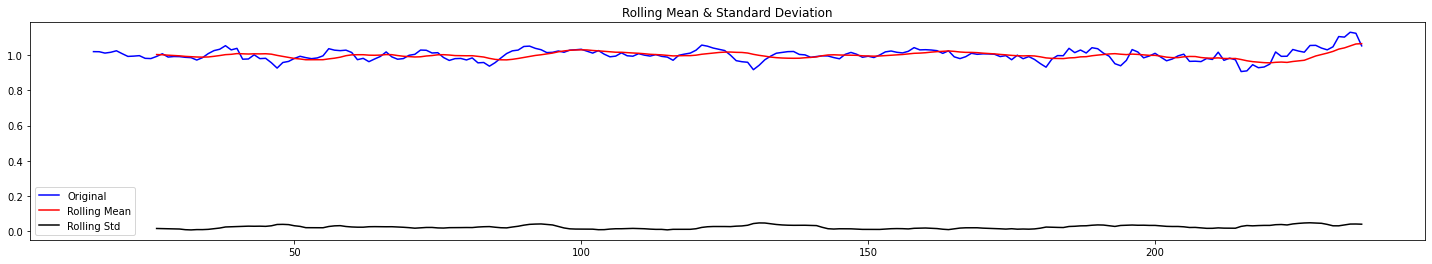

In [40]:
plot_rolling_statistics(rd_KOLD)

In [41]:
rd_KOLD.dropna(inplace=True)
augmented_dickey_fuller_test(rd_KOLD)

Results of Dickey-Fuller Test:
Test Statistic                  -5.053548
p-value                          0.000017
#Lags Used                       1.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


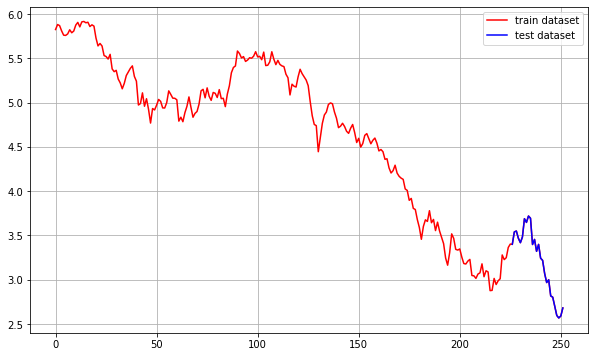

In [42]:
train_KOLD_data, test_KOLD_data = ts_KOLD_log[:int(len(ts_KOLD_log)*0.9)], ts_KOLD_log[int(len(ts_KOLD_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_KOLD_log, c='r' , label='train dataset')
plt.plot(test_KOLD_data, c='b', label='test dataset')        

plt.legend()


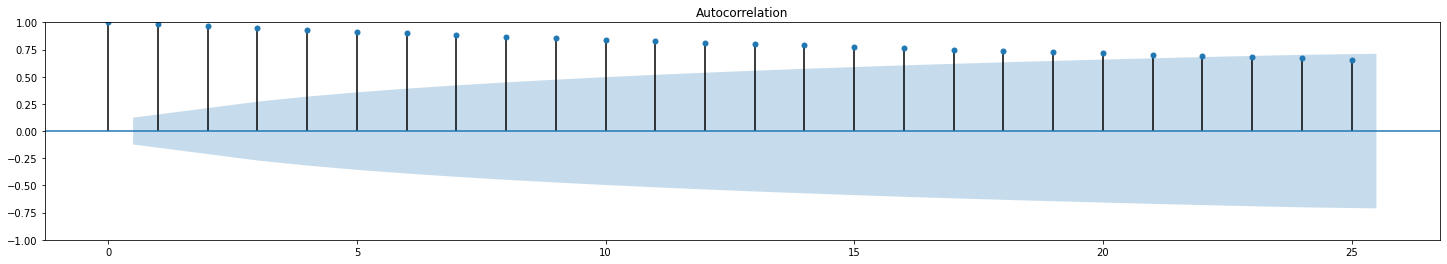

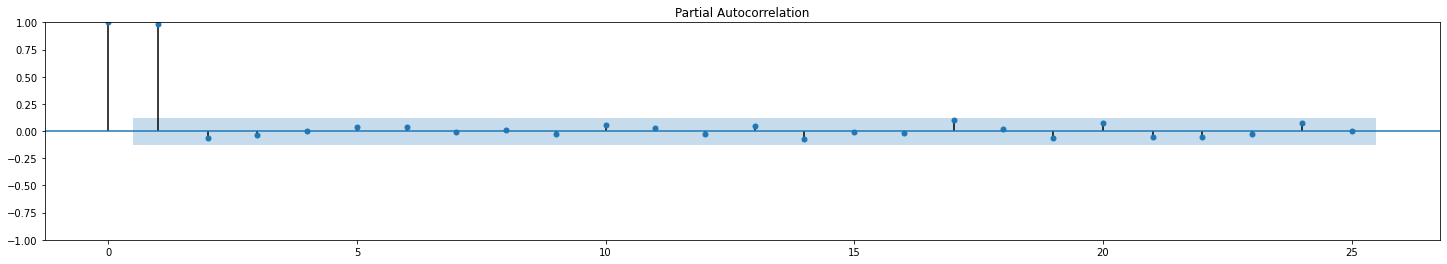

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_KOLD_log) 
plot_pacf(ts_KOLD_log) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.581464e+01
p-value                        1.036998e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


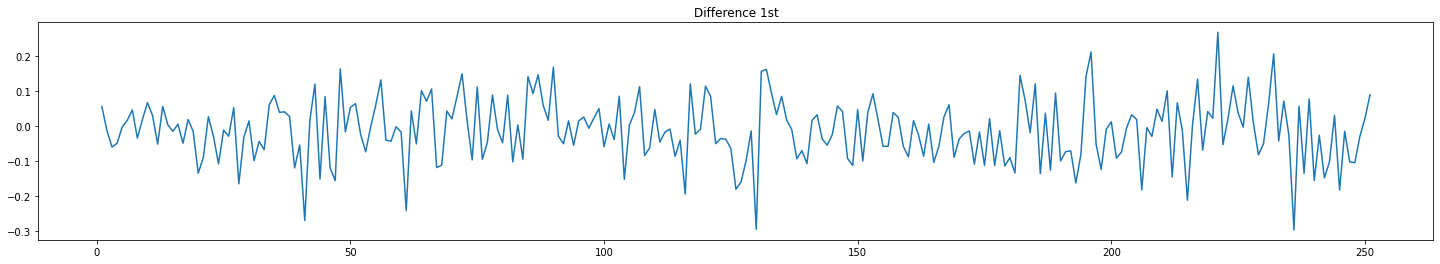

In [44]:
#1차 차분 구하기

diff_1 = ts_KOLD_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.643516e+00
p-value                        5.346601e-14
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


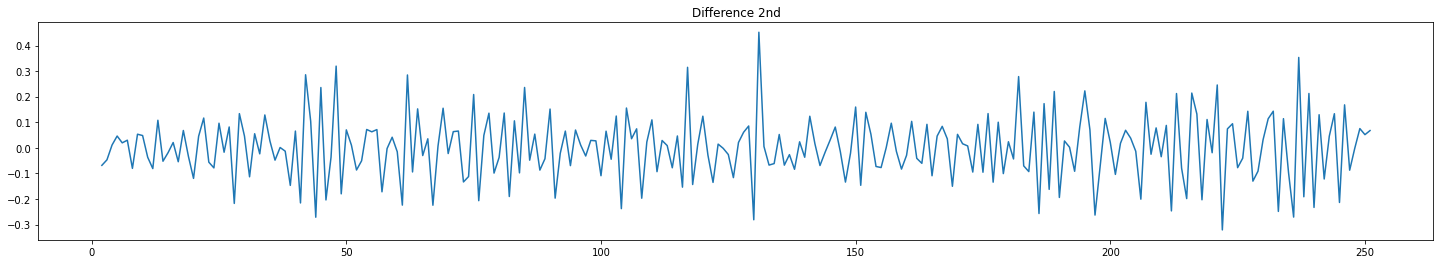

In [45]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [46]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_KOLD_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 227.678
Date:                Fri, 29 Jul 2022   AIC                           -451.356
Time:                        14:43:56   BIC                           -444.524
Sample:                             0   HQIC                          -448.599
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0207      0.066      0.314      0.754      -0.109       0.150
sigma2         0.0077      0.001     11.670      0.000       0.006       0.009
Ljung-Box (L1) (Q):                   0.05   Jarque-

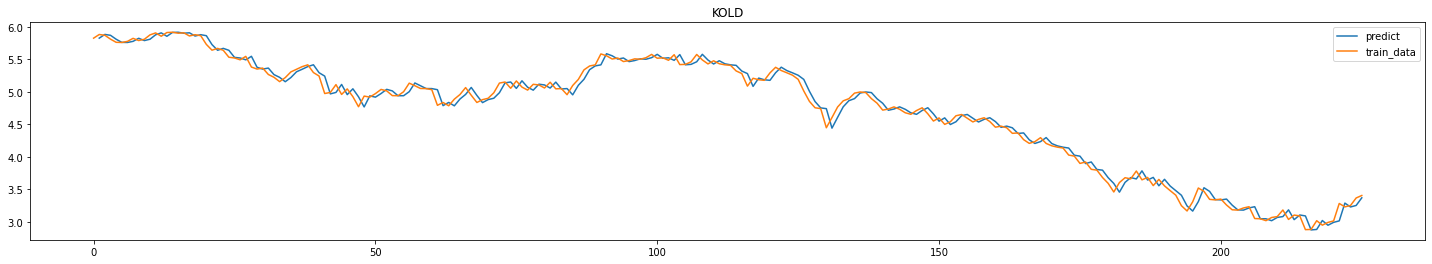

In [48]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_KOLD_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit()
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_KOLD_data, label='train_data')
plt.title('KOLD')
plt.legend()
plt.show()


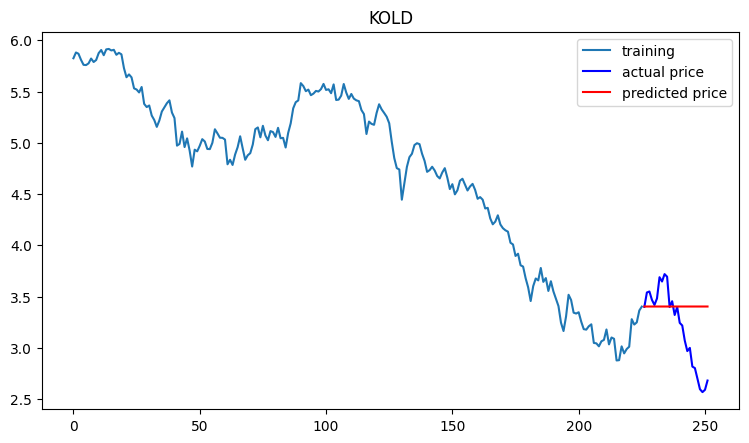

In [49]:
model = ARIMA(train_KOLD_data, order=(1, 1, 0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_KOLD_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_KOLD_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_KOLD_data, label='training')
plt.plot(test_KOLD_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.title('KOLD')
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_KOLD_data), np.exp(fc))
print('MSE:', mse)

mae = mean_absolute_error(np.exp(test_KOLD_data), np.exp(fc))
print('MAE:', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_KOLD_data), np.exp(fc)))
print('RMSE:', rmse )

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_KOLD_data))/np.abs(np.exp(test_KOLD_data)))
print('MAPE: {:.2f}%.'.format(mape*100))

MSE: 94.7863730799281
MAE: 7.869396654882271
RMSE: 9.735829347309252
MAPE: 41.77%.


# 다음

In [51]:
dataset_BOIL = '/content/drive/MyDrive/aiffel csv/BOIL.csv'
df_BOIL = pd.read_csv(dataset_BOIL)
ts_BOIL = df_BOIL['Close']

ts_BOIL.tail() 


247    86.699997
248    95.309998
249    97.809998
250    95.260002
251    86.209999
Name: Close, dtype: float64

Text(0.5, 1.0, 'BOIL')

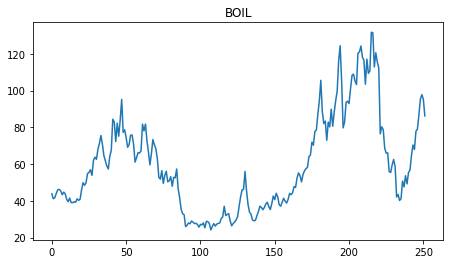

In [52]:
rcParams['figure.figsize'] = 25,4

plt.subplot(131)
plt.plot(ts_BOIL)
plt.title('BOIL')


In [53]:
print(ts_BOIL[ts_BOIL.isna()])

Series([], Name: Close, dtype: float64)


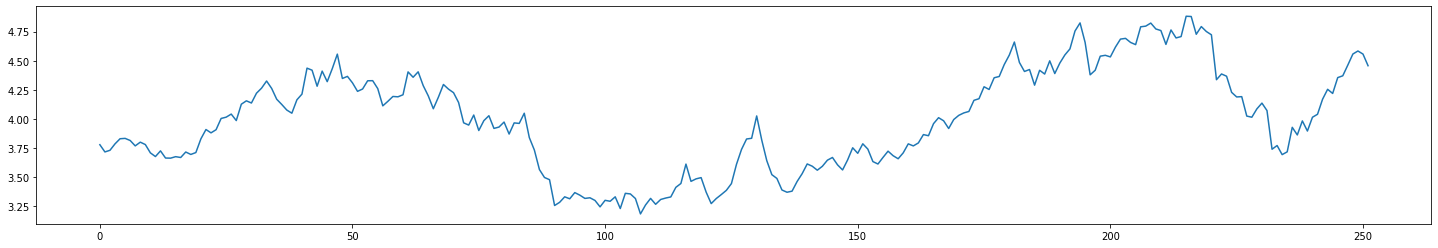

In [54]:
ts_BOIL_log = np.log(ts_BOIL)
plt.plot(ts_BOIL_log)


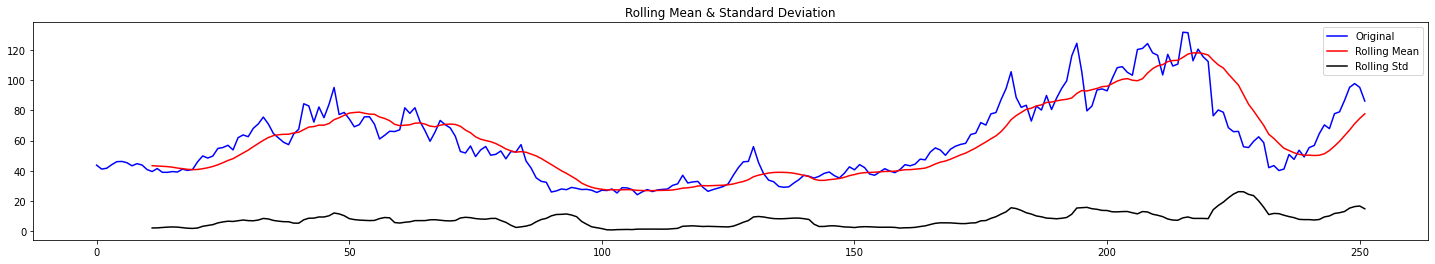

In [55]:
plot_rolling_statistics(ts_BOIL)

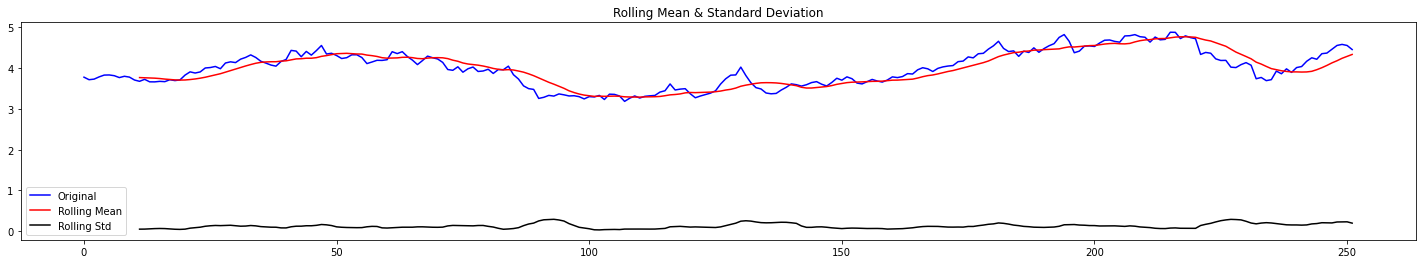

In [56]:
plot_rolling_statistics(ts_BOIL_log, window=12)

In [57]:
augmented_dickey_fuller_test(ts_BOIL_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.549415
p-value                          0.508941
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


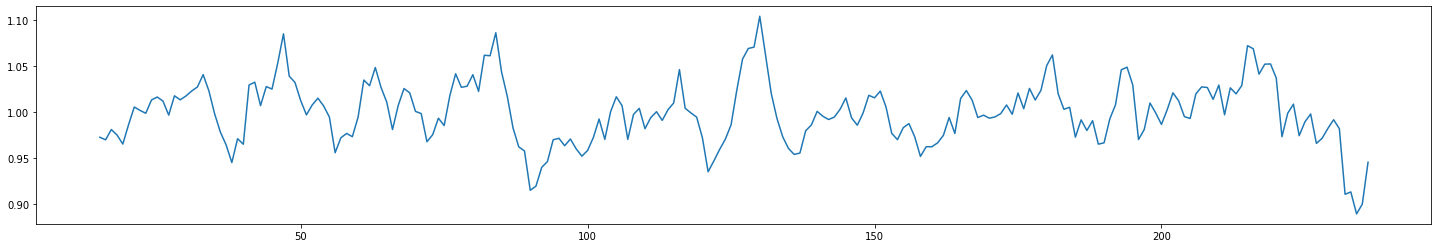

In [58]:
dp_BOIL = seasonal_decompose(ts_BOIL_log, model='multiplicative', period = 30)
rd_BOIL = dp_BOIL.resid
plt.plot(rd_BOIL)
plt.show()

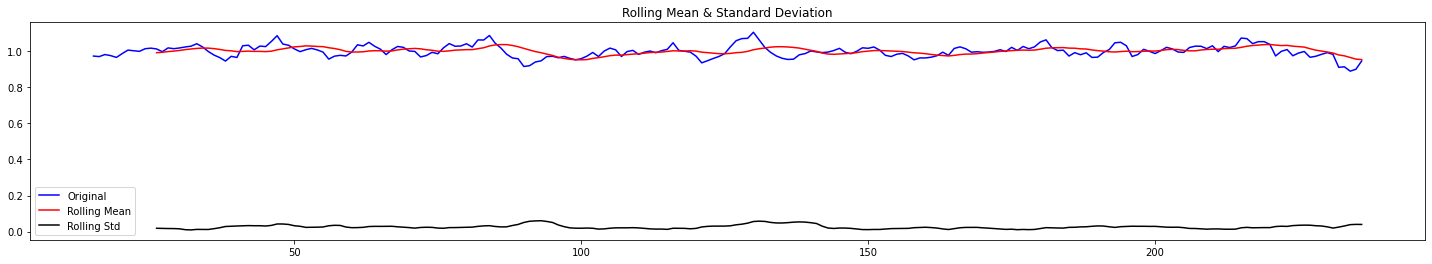

In [59]:
plot_rolling_statistics(rd_BOIL)

In [60]:
rd_BOIL.dropna(inplace=True)
augmented_dickey_fuller_test(rd_BOIL)

Results of Dickey-Fuller Test:
Test Statistic                -5.776057e+00
p-value                        5.256340e-07
#Lags Used                     3.000000e+00
Number of Observations Used    2.180000e+02
Critical Value (1%)           -3.460708e+00
Critical Value (5%)           -2.874891e+00
Critical Value (10%)          -2.573886e+00
dtype: float64


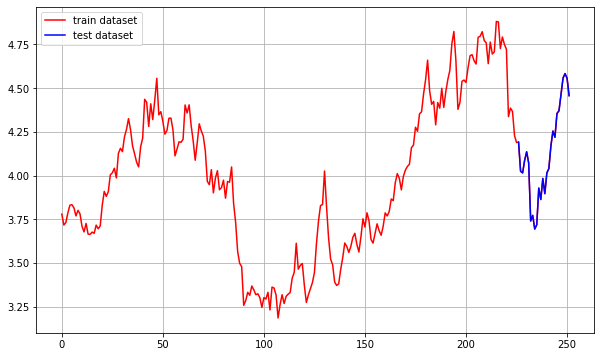

In [61]:
train_BOIL_data, test_BOIL_data = ts_BOIL_log[:int(len(ts_BOIL_log)*0.9)], ts_BOIL_log[int(len(ts_BOIL_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_BOIL_log, c='r' , label='train dataset')
plt.plot(test_BOIL_data, c='b', label='test dataset')        

plt.legend()


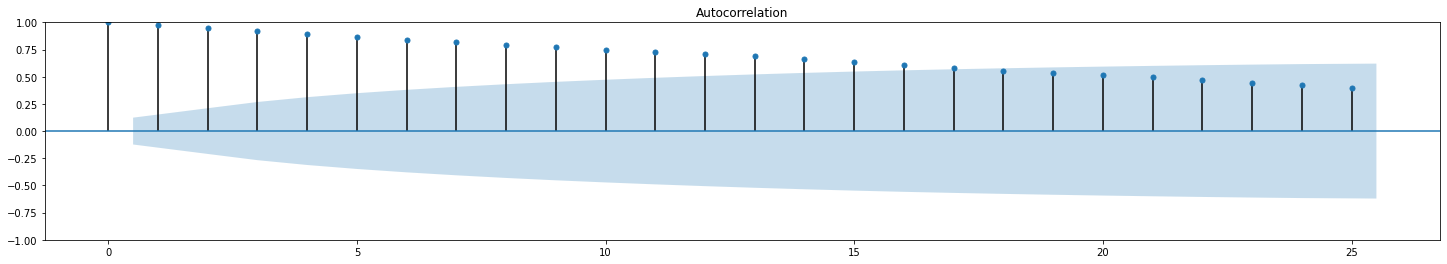

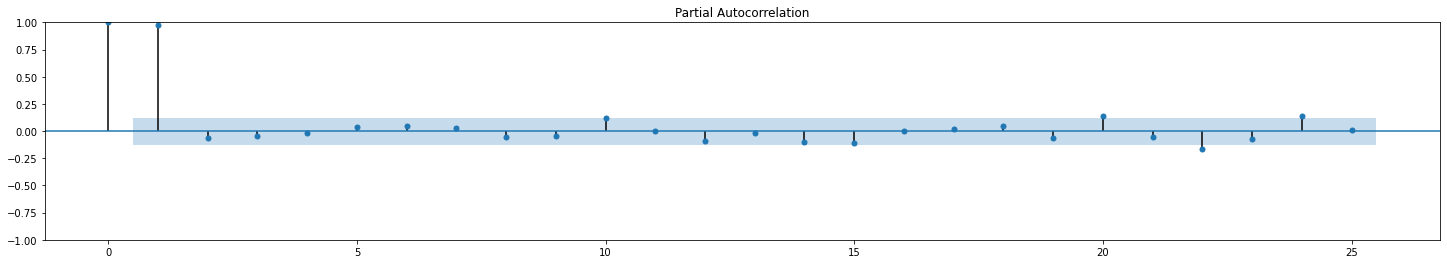

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_BOIL_log)
plot_pacf(ts_BOIL_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.541140e+01
p-value                        3.119969e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


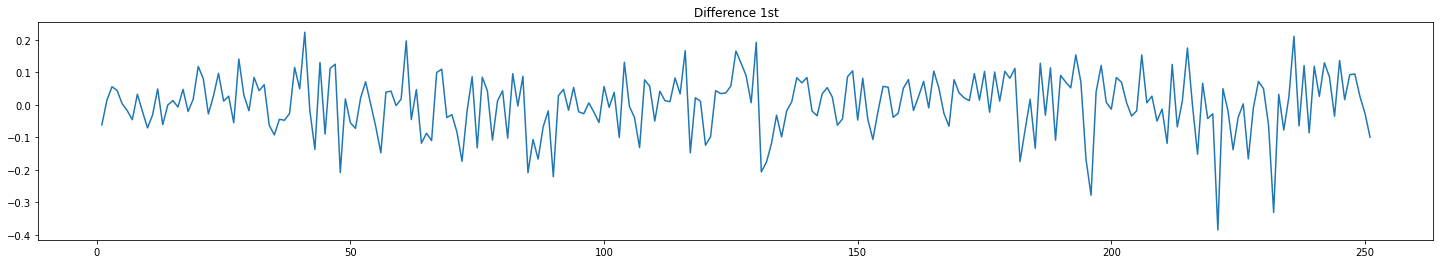

In [63]:

diff_1 = ts_BOIL_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.613220e+00
p-value                        6.392158e-14
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


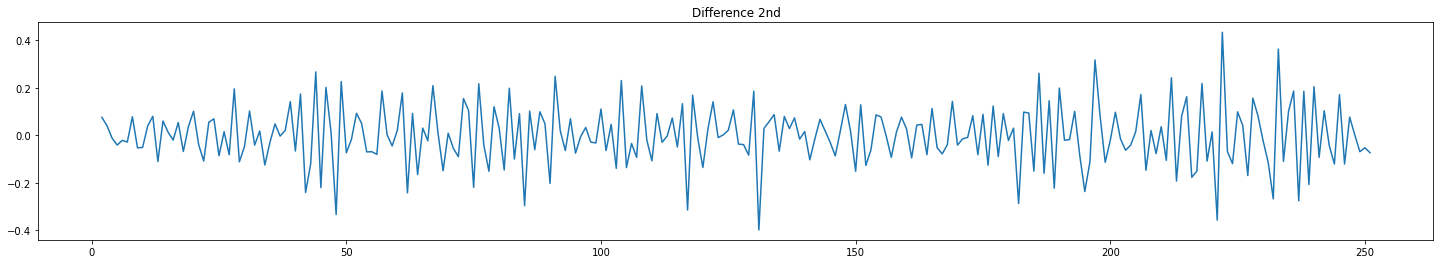

In [64]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [65]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_BOIL_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 224.247
Date:                Fri, 29 Jul 2022   AIC                           -444.494
Time:                        14:50:18   BIC                           -437.662
Sample:                             0   HQIC                          -441.736
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0270      0.065      0.418      0.676      -0.100       0.154
sigma2         0.0080      0.001     13.310      0.000       0.007       0.009
Ljung-Box (L1) (Q):                   0.00   Jarque-

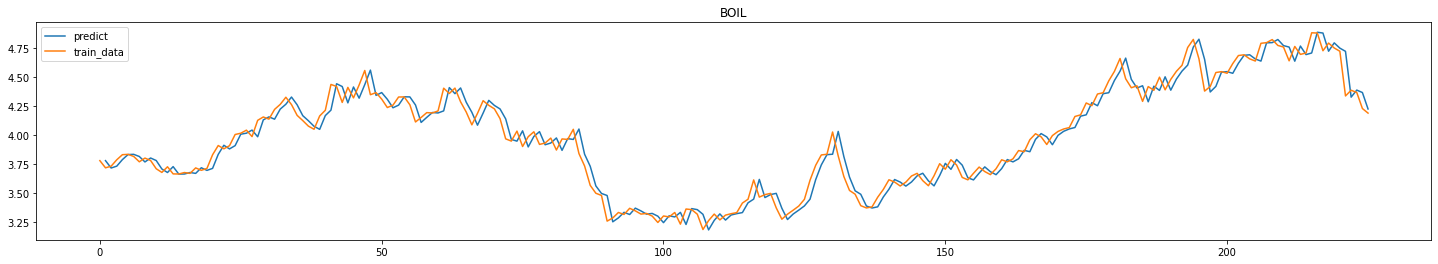

In [66]:
model = ARIMA(train_BOIL_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit()
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_BOIL_data, label='train_data')
plt.title('BOIL')
plt.legend()
plt.show()

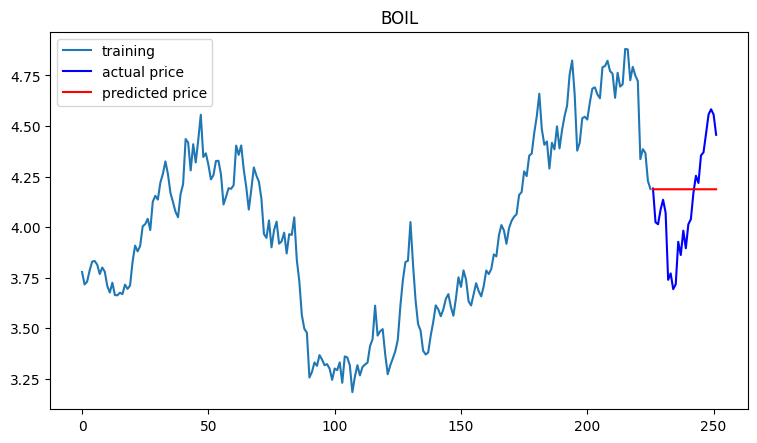

In [67]:
model = ARIMA(train_BOIL_data, order=(1, 1, 0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_BOIL_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_BOIL_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_BOIL_data, label='training')
plt.plot(test_BOIL_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.title('BOIL')
plt.show()

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_BOIL_data), np.exp(fc))
print('MSE:', mse)

mae = mean_absolute_error(np.exp(test_BOIL_data), np.exp(fc))
print('MAE:', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_BOIL_data), np.exp(fc)))
print('RMSE:', rmse )

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_BOIL_data))/np.abs(np.exp(test_BOIL_data)))
print('MAPE: {:.2f}%.'.format(mape*100))

MSE: 298.7267505665274
MAE: 14.640213877214254
RMSE: 17.2837134484036
MAPE: 24.69%.
